# Homework #3B
### Team A 22
## Import

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

## Data

In [11]:
df = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name = 1)
df = df.set_index('date')

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026
1926-03-31,-0.0577,0.0026
1926-04-30,0.0385,0.0023
1926-05-28,0.0136,0.0027


## 1.     Modeling Volatility and VaR

In [16]:
df[r'$\tilde{r}$'] = df['SPX'] - df['TB1M']
df.dropna(inplace = True)

### 1. Historic VaR
#### (a)

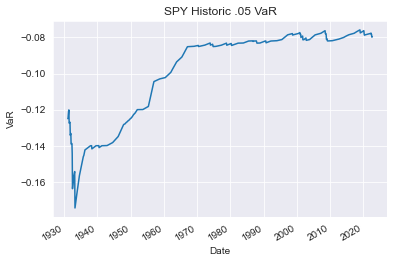

In [44]:
historic_VaR = df[r'$\tilde{r}$'].shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot()

plt.title('SPY Historic .05 VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

#### (b)

In [18]:
round(len(df[r'$\tilde{r}$'][df[r'$\tilde{r}$'] < historic_VaR]) / len(historic_VaR.dropna()), 5)

0.03033

#### (c)
- The violation rate is just above 3% while it should be 5% as specified by the VaR confidence level
- Estimating VaR through historic simulation seems to underestimate extreme returns.
- Smoother tail of the Historic VaR would lead to a more accurate estimation

### 2
#### (a)

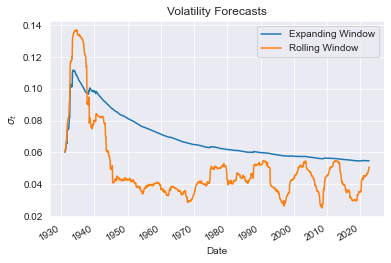

In [21]:
# Expanding Windows
stdev = np.sqrt((df[r'$\tilde{r}$']**2).shift(1).expanding(60).mean().to_frame('Expanding Window'))
# Rolling Window
stdev['Rolling Window'] = np.sqrt((df[r'$\tilde{r}$']**2).shift(1).rolling(60). mean())
# plot
stdev.dropna(inplace = True)

stdev.plot()

plt.title('Volatility Forecasts')
plt.ylabel(r'$\sigma_{t}$')
plt.xlabel('Date')
plt.show()

#### (b)

In [22]:
VaR = -1.65 * stdev
VaR.head()

,Expanding Window,Rolling Window
date,,
1931-01-31,-0.0992,-0.0992
1931-02-28,-0.0992,-0.1000
1931-03-31,-0.1010,-0.1024
1931-04-30,-0.1013,-0.1027
1931-05-29,-0.1023,-0.1043


#### (c)

In [23]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[df.loc[VaR.index, r'$\tilde{r}$'] < VaR[col]]) / len(VaR[col].dropna().index)

round(freq_df, 5)

,Expanding Window,Rolling Window
Frequency,0.0175,0.0496


#### (d)
- The Rolling Window seems to result in a higher violation frequency than the expanding window method
- The Rolling Window, which looks at the only 60 most recent excess returns, seems to be closer to the expected violation rate of 5% (4.96%)
- The expanding series method seems to result in a more conservative VaR than the historic simulation's.
- The rolling window method seems to result in a less conservative VaR than the historic simulation's.

### 3

In [107]:
def calc_cdf(data, normal = False, sigma = .0):
    if normal:
        threshold = -1.65 * sigma
    else:
        threshold = data.quantile(.05)

    return data[data < threshold].mean()

- Empirical CDF

#### (a)

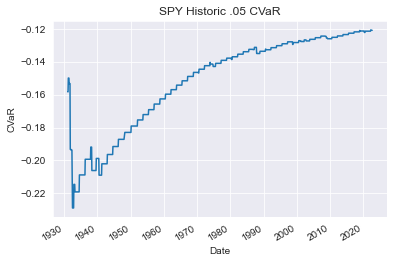

In [108]:
# empirical cdf
historic_CVaR = df[r'$\tilde{r}$'].shift().expanding(min_periods = 60).apply(calc_cdf)
historic_CVaR.plot()

plt.title('SPY Historic .05 CVaR')
plt.ylabel('CVaR')
plt.xlabel('Date')
plt.show()

#### (b)

In [109]:
round(len(df[r'$\tilde{r}$'][df[r'$\tilde{r}$'] < historic_CVaR]) / len(historic_CVaR.dropna()), 5)

0.00827

#### (c)
- The Historic CVaR is more conservative than the Historic VaR as suspected

- Expanding Volatility Estimates

In [137]:
# expanding volatility estimates
expanding_CVaR = []
for data in df[r'$\tilde{r}$'].shift(1).expanding(60):
    expanding_CVaR.append(calc_cdf(data = data, normal = True, sigma = np.sqrt(data**2).mean()))

- Rolling Volatility Estimates

In [135]:
# rolling volatility estimates
rolling_CVaR = []
for data in df[r'$\tilde{r}$'].shift(1).rolling(60):
    rolling_CVaR.append(calc_cdf(data = data, normal = True, sigma = np.sqrt(data**2).mean()))

In [148]:
CVaR_df = pd.DataFrame(index = df[r'$\tilde{r}$'][60:].index, columns = VaR.columns)
CVaR_df['Expanding Window'] = expanding_CVaR[60:]
CVaR_df['Rolling Window'] = rolling_CVaR[60:]
CVaR_df.head()

,Expanding Window,Rolling Window
date,,
1931-01-31,-0.1369,-0.1369
1931-02-28,-0.1369,-0.1369
1931-03-31,-0.1369,-0.1369
1931-04-30,-0.1369,-0.1369
1931-05-29,-0.1297,-0.1297


### 4
- EWMA

In [78]:
IGARCH = arch_model(df[r'$\tilde{r}$'])

theta = 0.97

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

Iteration:      1,   Func. Count:      3,   Neg. LLF: 3984570.5364937778
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1858.8039187809004
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1858.8039187817976
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


mu    0.007
Name: params, dtype: float64

- GARCH(1,1)

In [79]:
GARCH = arch_model(df[r'$\tilde{r}$'], vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 38084950.95951727
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1909.9199599735189
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1909.9199630529993
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          7.8426e-03
omega       5.8962e-05
alpha[1]    1.0000e-01
beta[1]     8.8000e-01
Name: params, dtype: float64

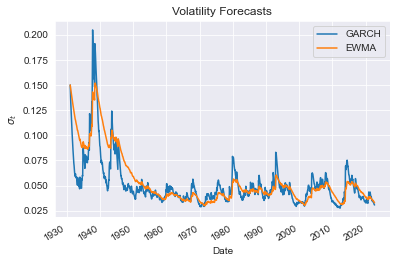

In [80]:
stdev[['GARCH','EWMA']] = None

### Initialize with the given parameter
stdev.iloc[0,2:] = 0.15

### Simulate the rest of the period using the initial stdev given
for i in range(1, len(stdev)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    stdev['EWMA'].iloc[i] = np.sqrt((stdev['EWMA'].iloc[i-1]**2) * theta \
                                    + (1-theta)*(df[r'$\tilde{r}$'].iloc[i-1]**2))
    stdev['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega']\
                                     + (stdev['GARCH'].iloc[i-1]**2) * GARCH_model.params['beta[1]']\
                                     + GARCH_model.params['alpha[1]']*(df[r'$\tilde{r}$'].iloc[i-1]**2))

stdev.dropna(inplace = True)

stdev[['GARCH','EWMA']].plot()

plt.title('Volatility Forecasts')
plt.ylabel(r'$\sigma_{t}$')
plt.xlabel('Date')
plt.show()

In [81]:
VaR_2 = -1.65 * stdev[['GARCH','EWMA']]
VaR_2.head()

,GARCH,EWMA
date,,
1931-01-31,-0.2475,-0.2475
1931-02-28,-0.2325,-0.2438
1931-03-31,-0.2193,-0.2403
1931-04-30,-0.2085,-0.2373
1931-05-29,-0.1969,-0.2339


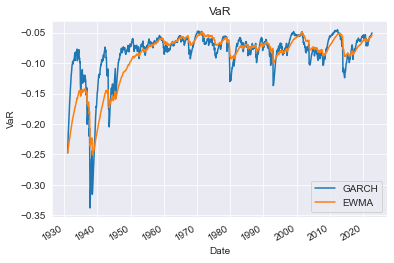

In [83]:
VaR_2.plot()

plt.title('VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

In [84]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR_2.columns)

for col in freq_df:
    freq_df[col] = len(VaR_2[df.loc[VaR_2.index, r'$\tilde{r}$'] < VaR_2[col]]) / len(VaR_2[col].dropna().index)

round(freq_df, 5)

,GARCH,EWMA
Frequency,0.0524,0.0469


## 3 Estimating Performance
### 1 Summary Statistics
#### (a)

In [38]:
log_df = np.log(1 + df)

log_df.head()

def annualized_stats(data, annual_factor, log = False):
    if log == False:
        df = pd.DataFrame(data = None,
                          index = [r'$r^{M}$',r'${\tilde{r}^{M}}$',r'$r^{f}$'])
    else:
        df = pd.DataFrame(data = None,
                      index = [r'log $r^{M}$',r'log ${\tilde{r}^{M}}$',r'log $r^{f}$'])

    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()]

    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] *= annual_factor

    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] = [data['SPX'].std(),
                                                                                   (data['SPX']-data['TB1M']).std(),
                                                                                   data['TB1M'].std()]

    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] *= np.sqrt(annual_factor)

    return df

def join(df_list):
    df = df_list[0]

    for df_ in df_list[1:]:
        df = df.join(df_)

    return df

stats_ = join([annualized_stats(df.loc['1965':'1999'], 12),
             annualized_stats(df.loc['2000':], 12),
             annualized_stats(df.loc['1926':], 12)])

log_stats = join([annualized_stats(log_df.loc['1965':'1999'], 12, log = True),
                 annualized_stats(log_df.loc['2000':], 12, log = True),
                 annualized_stats(log_df.loc['1926':], 12, log = True)])

stats_df = stats_.append(log_stats)
stats_df


,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2022 $\mu$,2000-2022 $\sigma$,1926-2022 $\mu$,1926-2022 $\sigma$
$r^{M}$,0.1302,0.1495,0.0759,0.1526,0.1132,0.1878
${\tilde{r}^{M}}$,0.0687,0.1502,0.0616,0.1531,0.0816,0.1881
$r^{f}$,0.0615,0.0072,0.0143,0.0050,0.0315,0.0086
log $r^{M}$,0.1184,0.1497,0.0640,0.1537,0.0953,0.1871
log ${\tilde{r}^{M}}$,0.0571,0.1504,0.0497,0.1542,0.0638,0.1873
log $r^{f}$,0.0613,0.0071,0.0143,0.0050,0.0315,0.0085


#### (b)
- The sub-sample volatility is lower than the full-sample volatility
- The average of sub-sample means is the full-sample mean
- The volatility for level stats are very similar to the log stats
- The mean for the log stats are lower than the mean for the level stats

### 2
#### (a)

In [39]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])

    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)

    prob_df = prob_df.set_index('h')

    return prob_df

mu_tilde = stats_df.iloc[4, 0]
sigma_tilde = stats_df.iloc[4, 1]
h = 2022 - 1999

prob([h], mu_tilde, sigma_tilde)

,Probability
h,
23,0.0344


### (b)

In [40]:
prob([15, 30], mu_tilde, sigma_tilde)

,Probability
h,
15,0.0708
30,0.0188


#### (c)

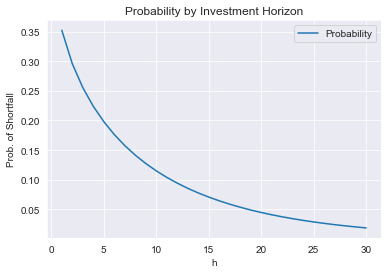

In [33]:
prob_horizon = prob(list(range(1, 31)), mu_tilde, sigma_tilde)

prob_horizon.plot()
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

### 3

In [34]:
log_df1965 = log_df.loc['1965':].dropna()
mu_tilde = (log_df1965['SPX'].mean()-log_df1965['TB1M'].mean()) * 12
sigma_tilde = (log_df1965['SPX']-log_df1965['TB1M']).std() * np.sqrt(12)

prob(list(range(1, 31)), mu_tilde, sigma_tilde)

,Probability
h,
1,0.3606
2,0.3069
3,0.2682
4,0.2377
5,0.2124
6,0.1910
7,0.1725
8,0.1563
9,0.1421


### 4
#### (a)

In [35]:
mu = stats_df.iloc[3,0]
bar_r = stats_df.iloc[3,2]
sigma = stats_df.iloc[3,1]

prob([23], mu - bar_r, sigma)

,Probability
h,
23,0.0408


#### (b)

In [41]:
strike = np.log(1.06)

mu65 = log_df1965['SPX'].mean() * 12

sigma65 = log_df1965['SPX'].std() * np.sqrt(12)

mu = 23/7 * (stats_df.iloc[3, 2] - strike) + mu65 - strike

prob([7], mu, sigma65)

,Probability
h,
7,0.1567
